# Projeto prático de Inteligencia artificial
Realizado por:
*   Amílcar Justino nº2222179
*   Diogo Abegão nº2222184


## Passos para elaboração do Modelo T


---


# Funções reutilizaveis



---
* Funcoes para desenhar os gráficos
* Funcao para desenhar a matriz de confusão


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

def plotLossAccuracy(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

def plotValidationLoss(history):
    print(history)
    val_loss = history.history["val_loss"]
    epochs = range(1, len(val_loss) + 1)
    plt.plot(epochs, val_loss, "b--",
    label="Validation loss")
    plt.title("Effect of insufficient model capacity on validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

# def plotConfusionMatrix(model, test_features, test_labels):
#     y_true = []
#     y_pred = []

#     print('Processing confusion matrix. May take some time...')
#     for images, labels in train_dataset:
#         y_true.extend(labels.numpy())
#         predictions = model.predict(images,verbose=0)
#         y_pred.extend(np.argmax(predictions, axis=1))

#     y_true = np.array(y_true)
#     y_pred = np.array(y_pred)
#     matrix = confusion_matrix(y_true, y_pred)
#     # Plot the confusion matrix
#     disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=test_dataset.class_names)
#     disp.plot(cmap=plt.cm.Blues, values_format='d')

#     plt.xticks(rotation=90)
#     plt.title('Confusion Matrix')
#     plt.show()

def plotConfusionMatrix(model, test_features, test_labels, class_names):
    # Predict the values from the test dataset
    predictions = model.predict(test_features)
    # Convert predictions to class labels
    y_pred = np.argmax(predictions, axis=1)

    # Plot confusion matrix
    matrix = confusion_matrix(test_labels, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')

    plt.xticks(rotation=90)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def plotOtherMetrics(model, test_dataset):
    y_true = []
    y_pred = []

    print('Processing test dataset. May take some time...')
    for images, labels in test_dataset:
        y_true.extend(labels.numpy())
        predictions = model.predict(images,verbose=0)
        y_pred.extend(np.argmax(predictions, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy}')
    precision = precision_score(y_true, y_pred, average='weighted')
    print(f'Precision: {precision}')
    recall = recall_score(y_true, y_pred, average='weighted')
    print(f'Recall: {recall}')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f'F1 Score: {f1}')

---


# Importaçao das imagens de treino, validação e teste.


---



In [ ]:
from keras.utils import image_dataset_from_directory
import os, shutil

IMG_SIZE = 150

BATCH_SIZE = 64

from google.colab import drive
drive.mount('/content/drive')

import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/train.zip", 'r')
zip_ref.extractall("/content/train")
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/validation.zip", 'r')
zip_ref.extractall("/content/validation")
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/test.zip", 'r')
zip_ref.extractall("/content/test")
zip_ref.close()


TRAIN_DIR = '/content/train/train'
VALIDATION_DIR = '/content/validation/validation'
TEST_DIR = '/content/test/test'

train_dataset = image_dataset_from_directory(TRAIN_DIR, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)
validation_dataset = image_dataset_from_directory(VALIDATION_DIR, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)
test_dataset = image_dataset_from_directory(TEST_DIR, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

Mounted at /content/drive
Found 40000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.




---


# Criação do modelo T


---
Mantendo a abordagem do modelo S, utilizando como base o apontamentos teóricos. Começamos pela construção do modelo T vamos utilizar o conceito de "Transfer Learning".
Primeiro vamos utilizar o "feature extraction" sem "data augmentation"
Para tal iremos começar pela importação do modelo VGG16, como seguido nas aulas. Retirando o classificador de modo a ser possível por um lado extrair as features obtidas através do modelo VGG e também para possibilitar a alteração do classificador visto que o classificador original do VGG16 está adaptado para 1000 classes, o que seria desnecessário tendo em conta que apenas queremos classificar 10 classes.


---
---

#Ensaio #1- feature extraction" sem "data augmentation"

---
---

Foram necessárias realizar algumas alterações ao classificador quando comparado com o modelo S, sendo uma delas a alteração do input do classificar pois neste ensaio as entradas não serão as imagens, mas sim as features extraidas do modelo VGG.

In [ ]:

from tensorflow import keras
from keras import layers

conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
print(conv_base.summary())


58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
import numpy as np
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []

  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)

  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 31ms/step


In [ ]:
np.save('/content/drive/MyDrive/models/ensaioT_1_train_features.npy', train_features)
np.save('/content/drive/MyDrive/models/ensaioT_1_train_labels.npy', train_labels)
np.save('/content/drive/MyDrive/models/ensaioT_1_validation_features.npy', val_features)
np.save('/content/drive/MyDrive/models/ensaioT_1_validation_labels.npy', val_labels)
np.save('/content/drive/MyDrive/models/ensaioT_1_test_features.npy', test_features)
np.save('/content/drive/MyDrive/models/ensaioT_1_test_labels.npy', test_labels)

In [ ]:
from numpy import load
train_features = load('/content/drive/MyDrive/models/ensaioT_1_train_features.npy')
train_labels = load('/content/drive/MyDrive/models/ensaioT_1_train_labels.npy')
val_features = load('/content/drive/MyDrive/models/ensaioT_1_validation_features.npy')
val_labels = load('/content/drive/MyDrive/models/ensaioT_1_validation_labels.npy')
test_features = load('/content/drive/MyDrive/models/ensaioT_1_test_features.npy')
test_labels = load('/content/drive/MyDrive/models/ensaioT_1_test_labels.npy')

In [ ]:
from keras import models

NUMBER_OF_EPOCHS = 30
LEARNING_RATE=0.001

inputs = keras.Input(shape=(4, 4, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

model.compile(
loss="sparse_categorical_crossentropy",
optimizer=keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),
metrics=["accuracy"])

callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="feature_extraction.keras",
save_best_only=True,
monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=NUMBER_OF_EPOCHS,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 4, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 2099978 (8.01 MB)
Trainable params: 2099978 (8.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
1250/1250 [=

313/313 [==============================] - 1s 3ms/step - loss: 18.7605 - accuracy: 0.8572
val_acc: 0.857200026512146
Test features shape: (10000, 4, 4, 512)
Test labels shape: (10000,)
(10000, 4, 4, 512)


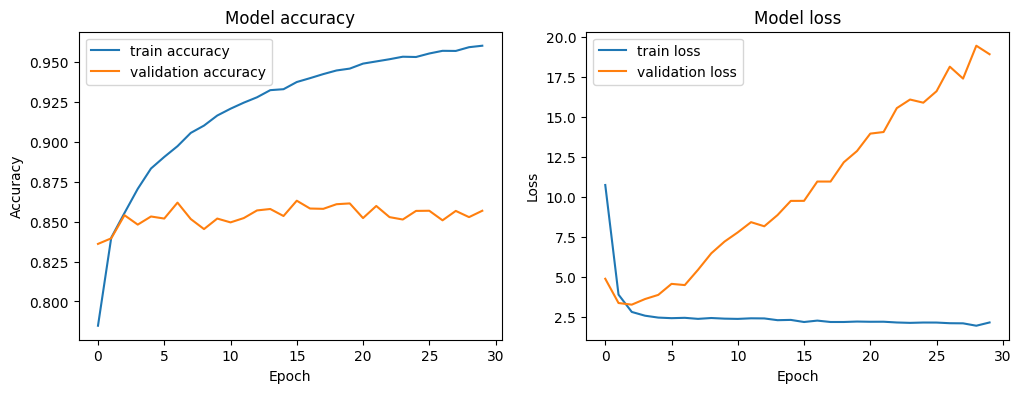

313/313 [==============================] - 1s 3ms/step


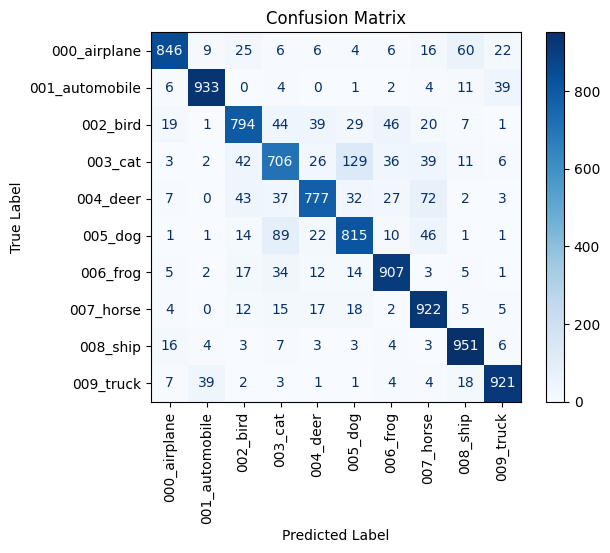

In [ ]:
val_loss, val_acc = model.evaluate(test_features, test_labels)
print('val_acc:', val_acc)

print('Test features shape:', test_features.shape)
print('Test labels shape:', test_labels.shape)

print(test_features.shape)

plotLossAccuracy(history)

class_names = [
    '000_airplane', '001_automobile', '002_bird', '003_cat',
    '004_deer', '005_dog', '006_frog', '007_horse',
    '008_ship', '009_truck'
]

plotConfusionMatrix(model, test_features, test_labels,class_names)

In [ ]:
model.save('/content/drive/MyDrive/models/ensaioT_1.h5')
model.save('/content/drive/MyDrive/models/ensaioT_1.keras')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
test_predictions = model.predict(test_features)
test_predictions_labels = np.argmax(test_predictions, axis=1)
precision = precision_score(test_labels, test_predictions_labels, average='weighted')
recall = recall_score(test_labels, test_predictions_labels, average='weighted')
f1 = f1_score(test_labels, test_predictions_labels, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

313/313 [==============================] - 1s 4ms/step
Precision: 0.857762132972511
Recall: 0.8572
F1 Score: 0.8564710445211206


# Interpretação de resultados: Ensaio 1

* Podemos verificar, como seria de esperar que se conseguiu uma accuracy superior à que conseguimos obter com o modelo S.
Estes resultados podem-se atribuir ao facto do treino do modelo VGG ser realizado com 1.2 milhões de imagens, conseguindo então extrair um maior número de features.

* Verificamos neste modelo uma accuracy de 85.7% com uma loss de cerca de 18.76.

* Analisando a matrix de confusão verificamos que o modelo apresenta maior facilidade em identificar alguns labels corretamente do que os restantes (ex: automobile, horse, ship, truck), apresentando algumas dificuldades em que labels (ex: bird, cat e deer).

* Verificamos que o modelo obteve Precision: 85% (indicando a proporção de positivos corretos),Recall: 85% (proporção de "reais" positivos identificados corretamente) e
F1 Score:85% (metrica de proporções entre precision e recall scores).

---
De modo a se conseguir a utilização do modelo treinado com VGG com o classificador personalizado, realizamos o "merge" das camadas, alterando o input para novamente aceitar as imagens de treino (ao invés das features como no ensaio 1).

In [ ]:
from keras import models
inputs = keras.Input(shape=(150, 150, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
outputs = model(x)
full_model = keras.Model(inputs, outputs)

In [ ]:
full_model.compile(
loss="sparse_categorical_crossentropy",
optimizer=keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),
metrics=["accuracy"])

In [ ]:
full_model.save('/content/drive/MyDrive/models/ensaioT_1_TL_without_data_augmentation.h5')

---
---

# Ensaio #2- "Transfer Learning" com "data augmentation" sem "fine tuning"

---
---

Neste ensaio iremos aplicar a técnica de data augmentation, iremos utilizar como base o modelo desenvolvido no ensaio 1, adicionando a técnica de data-augmentation de modo a tentar obter valor superior de accuracy através da introdução de alterações às imagens que se encontram na diretoria de treino.

In [ ]:
#Ensaio 2 with data augmentation
from tensorflow import keras
from keras import layers
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
import os

conv_base = VGG16(weights="imagenet", include_top=False)
conv_base.trainable = False

NUMBER_OF_EPOCHS = 30
LEARNING_RATE=0.001
IMG_SIZE = 150
BATCH_SIZE = 64


data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
 )

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 tf.__operators__.getitem_3  (None, 150, 150, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 150, 150, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0   

In [ ]:
model.compile(
  loss="sparse_categorical_crossentropy",
  optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
  metrics=["accuracy"])

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=5),
    keras.callbacks.ModelCheckpoint(filepath="checkpoint2_path.keras",monitor="val_loss",save_best_only=True),
]

#history = model.fit(train_dataset,epochs=30,validation_data=validation_dataset,callbacks=callbacks_list)

history = model.fit(train_dataset,epochs=30,validation_data=validation_dataset)

Epoch 1/30
625/625 [==============================] - 105s 165ms/step - loss: 2.4117 - accuracy: 0.7725 - val_loss: 1.9440 - val_accuracy: 0.8179
Epoch 2/30
625/625 [==============================] - 102s 164ms/step - loss: 2.3158 - accuracy: 0.7766 - val_loss: 1.8017 - val_accuracy: 0.8311
Epoch 3/30
625/625 [==============================] - 102s 163ms/step - loss: 2.3715 - accuracy: 0.7778 - val_loss: 2.0033 - val_accuracy: 0.8241
Epoch 4/30
625/625 [==============================] - 102s 163ms/step - loss: 2.4134 - accuracy: 0.7796 - val_loss: 1.8077 - val_accuracy: 0.8346
Epoch 5/30
625/625 [==============================] - 102s 163ms/step - loss: 2.4391 - accuracy: 0.7791 - val_loss: 1.9294 - val_accuracy: 0.8348
Epoch 6/30
625/625 [==============================] - 102s 163ms/step - loss: 2.4195 - accuracy: 0.7852 - val_loss: 1.6758 - val_accuracy: 0.8478
Epoch 7/30
625/625 [==============================] - 102s 163ms/step - loss: 2.4723 - accuracy: 0.7839 - val_loss: 1.9791 -

157/157 [==============================] - 20s 125ms/step - loss: 2.1204 - accuracy: 0.8592
val_acc: 0.8592000007629395


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


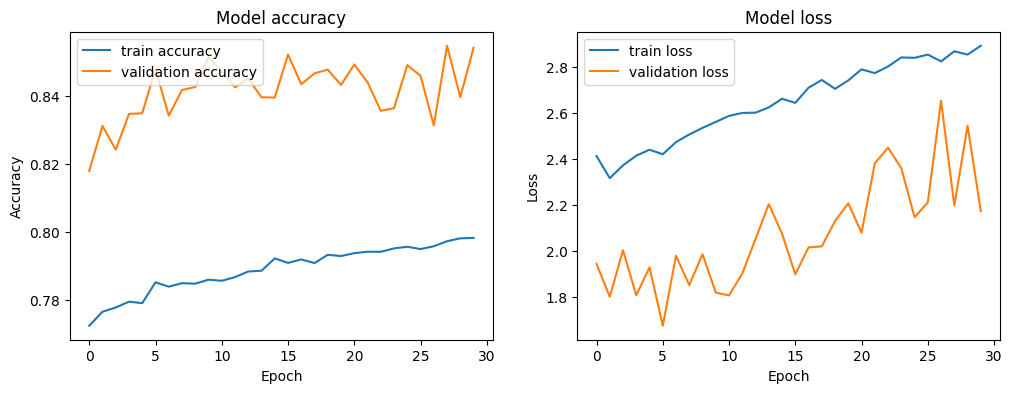

Processing confusion matrix. May take some time...


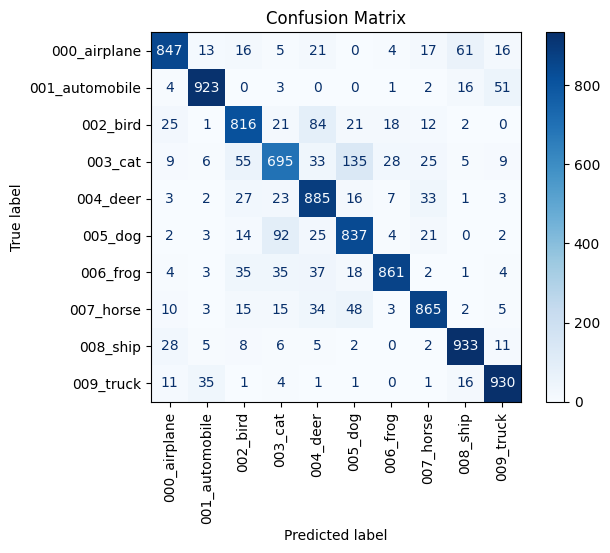

In [ ]:
val_loss, val_acc = model.evaluate(test_dataset)
print('val_acc:', val_acc)

model.save('/content/drive/MyDrive/models/ensaioT_2_TL_with_data_augmentation.h5')

plotLossAccuracy(history)

y_true = []
y_pred = []

print('Processing confusion matrix. May take some time...')
for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    predictions = model.predict(images,verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
matrix = confusion_matrix(y_true, y_pred)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=test_dataset.class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')

plt.xticks(rotation=90)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
plotOtherMetrics(model, test_dataset)

# Interpretação de resultados: Ensaio 2


*   Podemos verificar através observações dos valores da accuracy e loss, que o modelo com data augmentation obteve melhores resultados que o modelo sem data-augmentation , algo esperado tendo em conta a documentação, pois evitamos o overfitting, no treino do modelo. Verificamos até uma accuracy superior nas imagens de validação do que nas imagens de treino.
* Verificamos que apesar de valores mais baixos de accuracy nas training images, que a accuracy final não sofreu alterações em relação à accuracy do modelo sem data augmentation. Contudo verificamos que o modelo com data augmentation apresenta um valor muito inferior de loss relativamente ao modelo prévio.
*   Verificamos através da observação das matrixes de confusão que existe uma precisão superior na maioria das classes, mantendo contudo a dificuldade na identificação/precisão relativamente às classes anteriormente referidas, com maior enfasê na dificuldade da identificação da class "cat".
* Apresentando assim melhores metricas do que o modelo sem data augmentation.


Dificuldades relatadas:

* Previamos a realização de um modelo sem data augmentation mas com fine tuning, contudo após alguns testes verificamos dificuldades na implementação do mesmo, não conseguindo obter resultados do mesmo. Tendo isto em conta, optamos por não o colocar no relatório.
* Devido a dificuldades na implementação do mode.fit com a utilização de callback, após o termino da primeira epoch o modelo falhava ,optou-se por realizar os treinos dos modelos seguintes. Tais dificuldades não surgiam sem a utilização do callback.

---
---

# Ensaio #3- "Transfer Learning" com "data augmentation" com "fine tuning"

---
---



Neste ensaio iremos aplicar a técnica de fine tuning, iremos utilizar como base o modelo desenvolvido no ensaio 2. Esta técnica envolve o "unfreeze" de algumas camadas do modelo VGG permitindo que estas também sejam "treinadas", alterar os pesos nestas camadas. Esta técnica irá melhorar a performance do modelo, em princípio, devido à optimização das features que são extraidas do vgg. Deste ensaio estaremos não só a intervir na camada de classificação, mas também nas camadas escondidas.

Neste exemplo iremos optar por fazer o unfreeze das ultimas 4 camadas, tal como no exemplo da aula.

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/models/ensaioT_2_TL_with_data_augmentation.h5')
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:', val_acc)

157/157 [==============================] - 21s 128ms/step - loss: 2.1728 - accuracy: 0.8540
val_acc: 0.8539999723434448


In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, None, None, None   0         
                             )                                   
                                                                 
 tf.__operators__.getitem_3  (None, 150, 150, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 150, 150, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                           

In [ ]:
convbase = model.get_layer("vgg16")
convbase.trainable = True
for layer in convbase.layers[:-4]:
  layer.trainable = False
for i, layer in enumerate(convbase.layers):
  print(i, layer.name, layer.trainable)

0 input_9 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
model.summary()

model.compile(
  loss="sparse_categorical_crossentropy",
  optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
  metrics=["accuracy"])

#callbacks_list = [
#    keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=5),
#    keras.callbacks.ModelCheckpoint(filepath="checkpoint3_path.keras",monitor="val_loss",save_best_only=True),
#]

#history = model.fit(train_dataset,epochs=30,validation_data=validation_dataset,callbacks=callbacks_list)

history = model.fit(train_dataset,epochs=30,validation_data=validation_dataset)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, None, None, None   0         
                             )                                   
                                                                 
 tf.__operators__.getitem_3  (None, 150, 150, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 150, 150, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                           

157/157 [==============================] - 20s 127ms/step - loss: 0.5861 - accuracy: 0.9140
val_acc: 0.9139999747276306


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


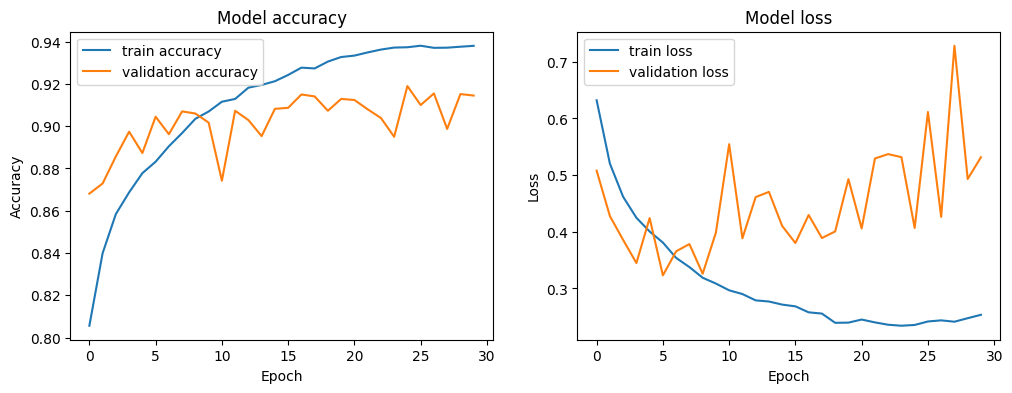

Processing confusion matrix. May take some time...


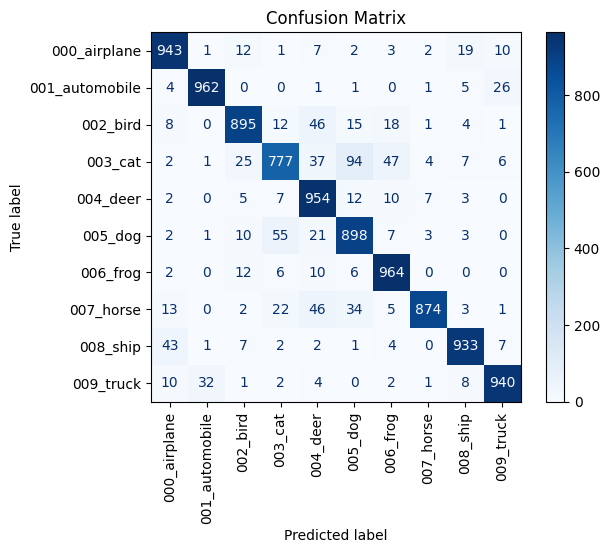

In [ ]:
val_loss, val_acc = model.evaluate(test_dataset)
print('val_acc:', val_acc)

model.save('/content/drive/MyDrive/models/ensaioT_3_TL_FT_with_data_augmentation.h5')

plotLossAccuracy(history)

#drawing the plot, example from ModelS
y_true = []
y_pred = []

print('Processing confusion matrix. May take some time...')
for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    predictions = model.predict(images,verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
matrix = confusion_matrix(y_true, y_pred)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=test_dataset.class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')

plt.xticks(rotation=90)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
plotOtherMetrics(model, test_dataset)

# Interpretação de resultados: Ensaio 3


*   Podemos verificar melhorias em todas as métricas relativamente ao modelos prévios, modelos S e T. Conseguindo neste modelo uma accuracy de 91.4% e um loss de 58%, valores mais altas e mais baixos obtido, respetivamente.

* Apresentadas melhores metricas ,em todos os parametros, relativamente aos restantes modelos, contudo mantém dificuldades, relativamente às restantes classes, na classificação de "cat". Apesar desta dificuldade apresentou valores de precisão para essa classe superiores aos restantes modelos, tal como ocorreu nas restantes classes.


Dificuldades relatadas:

* impressibilidade do treino do modelo, foi necessário realizar várias "tentativas" de modo a conseguir um modelo que apresenta-se valores superiores ao referidos previamente, sendo necessário alterar a learning rate do modo, podes verificavamos que inicialmente o modelo apresentava accuracys baixas(0.1), mantendo-as ao longo de varias epochs, optando por parar o treino nestas situações. Potencialmente encontrando um máximo local e não a solução "mais ótima".

*  Verificamos devido a  um aumento da loss, sendo este modelo possível a utilização de early stopping ou callbacks (nos cenários de falhas).

#Conclusão


*   A criação deste projeto modelo T, envolveu um processo incremental de optimização do modelo, através da utilização de técnicas de optimização como a utilização de modelos "pré-treinados", data-augmentation e fine-tuning, entre outros. De modo a se conseguir incrementalmente desenvolver um modelo com melhores carateristicas, tendo em conta o dataset fornecido.
*   Verificação que utilização de técnicas como early stopping e callbacks para melhorar o treino dos modelos.

* Como o nosso sistema tem clases balanceadas, a "accuracy" transmite uma ideia representativa do desempenho global do modelo. Podendo extrair desta afirmação que se obteve bons resultados na optimização do modelo através da accuracy obtida no último modelo.

---
Notas gerais para melhoria:


*   Potencial utilização de técnicas como BatchNormalization, do ReduceLROnPlateau, do Regularizer L1L2 (Regularizer l1 em conjunto com o Regularizer l2) e o dropout no modelo de classificação puderiam, potencialmente, levar a ainda melhores resultados.

* Implementação dos metodos de callback e early-stopping nos modelos com data-augmentation.



# Funcionalidades utilizadas durante este trabalho pratico


*   Feature Extration
*   Data Augmentation
* Fine Tuning
* optimizers.RSprop

